## Import Libraries

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier


## Read dataset and vocabulary

In [296]:
df_train = pd.read_csv('data/train_preprocess.tsv', sep='\t', names=['text', 'label'])
df_val = pd.read_csv('data/valid_preprocess.tsv', sep='\t', names=['text', 'label'])
df_test = pd.read_csv('data/test_preprocess.tsv', sep='\t', names=['text', 'label'])
# df_test_masked = pd.read_csv('data/test_preprocess_masked_label.tsv', sep='\t', names=['text', 'label'])

In [297]:
with open('data/vocab.txt', 'r') as f:
	vocab = f.read().splitlines()
print(len(vocab))
with open('data/vocab_uncased.txt', 'r') as f:
	vocab_uncased = f.read().splitlines()
print(len(vocab_uncased))

19521
19520


## EDA

In [211]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11000 non-null  object
 1   label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [212]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1260 non-null   object
 1   label   1260 non-null   object
dtypes: object(2)
memory usage: 19.8+ KB


In [213]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    500 non-null    object
 1   label   500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


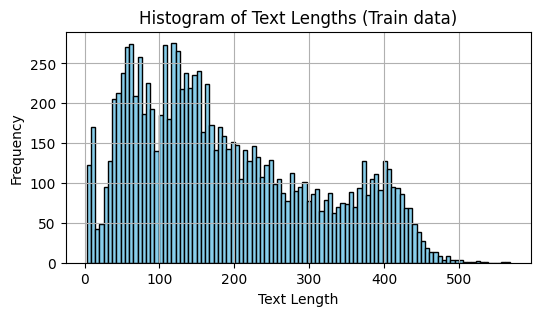

In [214]:
# Plotting the histogram of text lengths
plt.figure(figsize=(6, 3))
plt.hist(df_train['text'].apply(len), bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Text Lengths (Train data)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


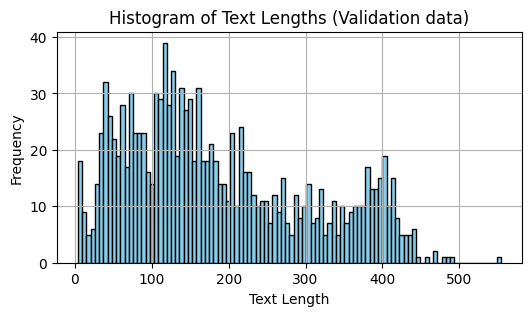

In [215]:
# Plotting the histogram of text lengths
plt.figure(figsize=(6, 3))
plt.hist(df_val['text'].apply(len), bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Text Lengths (Validation data)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


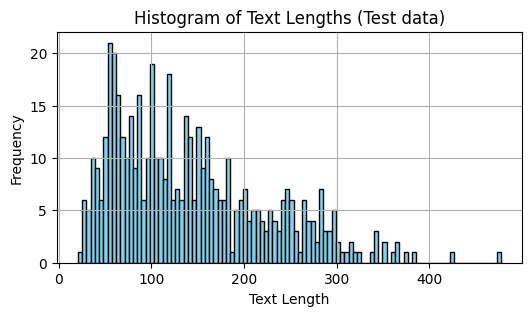

In [216]:
# Plotting the histogram of text lengths
plt.figure(figsize=(6, 3))
plt.hist(df_test['text'].apply(len), bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Text Lengths (Test data)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [298]:
# Longer tokens are matched first
vocab.sort(key=len, reverse=True)
vocab_uncased.sort(key=len, reverse=True)

In [221]:
# Skimming through the text data
for text in df_train['text'].values:
	print(text)

warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !
mohon ulama lurus dan k212 mmbri hujjah partai apa yang harus diwlh agar suara islam tidak pecah-pecah
lokasi strategis di jalan sumatera bandung . tempat nya nyaman terutama sofa di lantai 2 . paella nya enak , sangat pas dimakan dengan minum bir dingin . appetiser nya juga enak-enak .
betapa bahagia nya diri ini saat unboxing paket dan barang nya bagus ! menetapkan beli lagi !
duh . jadi mahasiswa jangan sombong dong . kasih kartu kuning segala . belajar dulu yang baik , tidak usahlah ikut-ikut politik . nanti sudah selesai kuliah nya mau ikut politik juga tidak telat . dasar mahasiswa 

In [232]:
# COUNTING THE OCCURENCES OF EACH TOKEN IN THE TRAINING, VALIDATION AND TEST SETS
# Create a search pattern for the tokens
vocab_search_pattern = '|'.join(re.escape(token) for token in vocab)
vocab_search_pattern_uncased = '|'.join(re.escape(token) for token in vocab_uncased)

# Initialize the frequency dictionaries
freq_vocab_train = {key: 0 for key in vocab}
freq_vocab_val = {key: 0 for key in vocab}
freq_vocab_test = {key: 0 for key in vocab}
freq_vocab_all = {key: 0 for key in vocab}

# Count the occurences of each token in the training, validation and test sets
for text in df_train['text'].values:
	for token_found in re.findall(vocab_search_pattern, text):
		freq_vocab_train[token_found] += 1
		freq_vocab_all[token_found] += 1

for text in df_val['text'].values:
	for token_found in re.findall(vocab_search_pattern, text):
		freq_vocab_val[token_found] += 1
		freq_vocab_all[token_found] += 1

for text in df_test['text'].values:
	for token_found in re.findall(vocab_search_pattern, text):
		freq_vocab_test[token_found] += 1
		freq_vocab_all[token_found] += 1

In [223]:
# Vocab difference between vocab and vocab_uncased
set(vocab) - set(vocab_uncased)

{'Jakarta'}

In [224]:
# Dataframe of the token frequencies
data_freq_tokens = {
    'token': list(freq_vocab_train.keys()),
    'freq_train': list(freq_vocab_train.values()),
    'freq_val': list(freq_vocab_val.values()),
    'freq_test': list(freq_vocab_test.values()),
    'freq_all': list(freq_vocab_all.values())
}
df_freq_tokens = pd.DataFrame(data_freq_tokens)
df_freq_tokens

,token,freq_train,freq_val,freq_test,freq_all
0,grinningfacewithsmilingeyes,1,0,0,1
1,beamingfacewithsmilingeyes,4,0,0,4
2,smilingfacewithsmilingeyes,1,0,0,1
3,twitter.com/cinema21/statu,0,1,0,1
4,backhandindexpointingdown,0,1,0,1
...,...,...,...,...,...
19516,s,57,6,1,64
19517,t,8,0,0,8
19518,v,10,3,0,13
19519,x,15,2,2,19


In [225]:
# Check if there is any token that is not occuring in the dataset
df_freq_tokens.sort_values(by='freq_all', ascending=True)

,token,freq_train,freq_val,freq_test,freq_all
0,grinningfacewithsmilingeyes,1,0,0,1
10212,terdapt,1,0,0,1
10213,terdiam,1,0,0,1
10223,terkaya,0,0,1,1
10225,terkian,1,0,0,1
...,...,...,...,...,...
18395,dan,7894,858,140,8892
18055,yang,9337,1049,251,10637
18763,nya,13474,1566,327,15367
19479,",",16021,1859,482,18362


In [226]:
# Check most frequent tokens
df_freq_tokens.sort_values(by='freq_train', ascending=False).head(15)

,token,freq_train,freq_val,freq_test,freq_all
19481,.,23912,2679,1042,27633
19479,",",16021,1859,482,18362
18763,nya,13474,1566,327,15367
18055,yang,9337,1049,251,10637
18395,dan,7894,858,140,8892
19245,di,7718,855,189,8762
15939,tidak,4399,467,271,5137
17724,saya,4309,418,172,4899
11013,dengan,4025,440,86,4551
8951,makanan,3563,387,11,3961


In [227]:
df_freq_tokens.sort_values(by='freq_train', ascending=False).to_csv('data/freq_tokens.tsv', sep='\t', index=False)

In [228]:
# Data count per labels
print("-------- Train data --------")
print(df_train['label'].value_counts())
print("\n-------- Validation data --------")
print(df_val['label'].value_counts())
print("\n-------- Test data --------")
print(df_test['label'].value_counts())

-------- Train data --------
label
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

-------- Validation data --------
label
positive    735
negative    394
neutral     131
Name: count, dtype: int64

-------- Test data --------
label
positive    208
negative    204
neutral      88
Name: count, dtype: int64


## Feature Extraction & Preprocessing

In [300]:
# Encoding the labels
df_train['label-encoded'] = df_train['label'].map({'positive': 1, 'negative': 0, 'neutral': 2})
df_val['label-encoded'] = df_val['label'].map({'positive': 1, 'negative': 0, 'neutral': 2})
df_test['label-encoded'] = df_test['label'].map({'positive': 1, 'negative': 0, 'neutral': 2})
df_train

,text,label,label-encoded
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,1
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,2
2,lokasi strategis di jalan sumatera bandung . t...,positive,1
3,betapa bahagia nya diri ini saat unboxing pake...,positive,1
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,0
...,...,...,...
10995,tidak kecewa,positive,1
10996,enak rasa masakan nya apalagi kepiting yang me...,positive,1
10997,hormati partai-partai yang telah berkoalisi,neutral,2
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative,0


In [303]:
# Get bag of words vector from the text
def get_bag_of_words(text, vocab, search_pattern):
	bag_of_words = np.zeros(len(vocab))
	for token_found in re.findall(search_pattern, text):
		bag_of_words[vocab.index(token_found)] += 1
	return bag_of_words

In [304]:
# Apply the function to the text column
df_series_np_train = df_train['text'].apply(lambda x: get_bag_of_words(x, vocab, vocab_search_pattern))
df_series_np_val = df_val['text'].apply(lambda x: get_bag_of_words(x, vocab, vocab_search_pattern))
df_series_np_test = df_test['text'].apply(lambda x: get_bag_of_words(x, vocab, vocab_search_pattern))

df_series_np_train_lower = df_train['text'].apply(lambda x: get_bag_of_words(x.lower(), vocab_uncased, vocab_search_pattern))
df_series_np_val_lower = df_val['text'].apply(lambda x: get_bag_of_words(x.lower(), vocab_uncased, vocab_search_pattern))
df_series_np_test_lower = df_test['text'].apply(lambda x: get_bag_of_words(x.lower(), vocab_uncased, vocab_search_pattern))

In [305]:
# Convert the series to numpy array
X_train = np.vstack(df_series_np_train.to_numpy())
X_val = np.vstack(df_series_np_val.to_numpy())
X_test = np.vstack(df_series_np_test.to_numpy())

X_train_lower = np.vstack(df_series_np_train_lower.to_numpy())
X_val_lower = np.vstack(df_series_np_val_lower.to_numpy())
X_test_lower = np.vstack(df_series_np_test_lower.to_numpy())

In [306]:
# Convert the labels to numpy array
y_train = df_train['label-encoded'].to_numpy().astype(np.float64)
y_val = df_val['label-encoded'].to_numpy().astype(np.float64)
y_test = df_test['label-encoded'].to_numpy().astype(np.float64)

In [307]:
# Convert it back to dataframe to get the column names
X_train_df = pd.DataFrame(X_train, columns=vocab)
X_val_df = pd.DataFrame(X_val, columns=vocab)
X_test_df = pd.DataFrame(X_test, columns=vocab)

X_train_lower_df = pd.DataFrame(X_train_lower, columns=vocab_uncased)
X_val_lower_df = pd.DataFrame(X_val_lower, columns=vocab_uncased)
X_test_lower_df = pd.DataFrame(X_test_lower, columns=vocab_uncased)

In [308]:
# Drop these special characters
special_characters = [
    "!", "$", "%", "(", ")", ",", "-", ".", ". .", "..", "...", "/", 
    ":", ":/", "::", ";", "<", "=", ">", "?"
]
X_train_df_drop = X_train_lower_df.drop(columns=special_characters)
X_val_df_drop = X_val_lower_df.drop(columns=special_characters)
X_test_df_drop = X_test_lower_df.drop(columns=special_characters)

## Modeling

### Naive Bayes

#### Without preprocess

In [312]:
model_nb = MultinomialNB()
model_nb.fit(X_train_df, y_train)
y_pred_nb = model_nb.predict(X_val_df)
print(classification_report(y_val, y_pred_nb, digits=4))

              precision    recall  f1-score   support

         0.0     0.7762    0.8452    0.8092       394
         1.0     0.9003    0.8966    0.8984       735
         2.0     0.8687    0.6565    0.7478       131

    accuracy                         0.8556      1260
   macro avg     0.8484    0.7994    0.8185      1260
weighted avg     0.8582    0.8556    0.8549      1260



In [313]:
df_importance_nb = pd.DataFrame(model_nb.feature_log_prob_.T, columns=['negative', 'positive', 'neutral'], index=list(X_train_df.columns))
df_importance_nb['positive-negative'] = df_importance_nb['positive'] - df_importance_nb['negative']
df_importance_nb['neutral-negative'] = df_importance_nb['neutral'] - df_importance_nb['negative']
df_importance_nb['neutral-positive'] = df_importance_nb['neutral'] - df_importance_nb['positive']
df_importance_nb['neutral-sum'] = df_importance_nb['neutral-negative'] + df_importance_nb['neutral-positive']
df_importance_nb

,negative,positive,neutral,positive-negative,neutral-negative,neutral-positive,neutral-sum
grinningfacewithsmilingeyes,-10.832507,-12.554692,-10.504410,-1.722185,0.328097,2.050282,2.378380
beamingfacewithsmilingeyes,-11.525654,-11.168398,-9.811263,0.357256,1.714392,1.357135,3.071527
smilingfacewithsmilingeyes,-10.832507,-12.554692,-10.504410,-1.722185,0.328097,2.050282,2.378380
twitter.com/cinema21/statu,-11.525654,-12.554692,-10.504410,-1.029038,1.021244,2.050282,3.071527
backhandindexpointingdown,-11.525654,-12.554692,-10.504410,-1.029038,1.021244,2.050282,3.071527
...,...,...,...,...,...,...,...
s,-8.960705,-8.841120,-8.712650,0.119585,0.248054,0.128470,0.376524
t,-10.832507,-10.475251,-10.504410,0.357256,0.328097,-0.029159,0.298938
v,-9.579744,-11.168398,-9.811263,-1.588654,-0.231519,1.357135,1.125617
x,-10.139360,-10.357468,-8.894972,-0.218108,1.244388,1.462496,2.706884


In [314]:
df_importance_nb.sort_values(by='positive-negative', ascending=False).head(10)

,negative,positive,neutral,positive-negative,neutral-negative,neutral-positive,neutral-sum
lezat,-10.832507,-7.328946,-10.504410,3.503561,0.328097,-3.175464,-2.847367
ketagihan,-11.525654,-8.054883,-10.504410,3.470772,1.021244,-2.449527,-1.428283
terjangkau,-9.916216,-6.657538,-10.504410,3.258678,-0.588194,-3.846871,-4.435065
soto,-11.525654,-8.603449,-9.405798,2.922206,2.119857,-0.802349,1.317508
terjun,-11.525654,-8.642669,-10.504410,2.882985,1.021244,-1.861741,-0.840496
gurih,-10.427042,-7.564260,-9.811263,2.862782,0.615779,-2.247003,-1.631224
berbagai,-9.916216,-7.057524,-8.712650,2.858692,1.203566,-1.655126,-0.451560
bakmoy,-11.525654,-8.726051,-10.504410,2.799603,1.021244,-1.778359,-0.757115
padma,-11.525654,-8.770503,-10.504410,2.755152,1.021244,-1.733907,-0.712663
mantap,-9.446213,-6.691061,-8.894972,2.755152,0.551241,-2.203911,-1.652670


In [315]:
df_importance_nb.sort_values(by='positive-negative', ascending=True).head(10)

,negative,positive,neutral,positive-negative,neutral-negative,neutral-positive,neutral-sum
goblok,-7.465211,-12.554692,-10.504410,-5.089481,-3.039199,2.050282,-0.988916
pki,-7.633834,-12.554692,-9.118115,-4.920858,-1.484282,3.436577,1.952295
dpr,-7.836775,-12.554692,-7.137114,-4.717918,0.699661,5.417578,6.117239
sesat,-7.862092,-12.554692,-10.504410,-4.692600,-2.642317,2.050282,-0.592035
lgbt,-7.888068,-12.554692,-9.811263,-4.666624,-1.923195,2.743430,0.820235
korupsi,-8.091667,-12.554692,-8.424968,-4.463025,-0.333301,4.129724,3.796423
anjing,-7.071307,-11.456080,-10.504410,-4.384773,-3.433103,0.951670,-2.481433
indosat,-6.569827,-10.945254,-8.558500,-4.375427,-1.988673,2.386755,0.398082
pencitraan,-8.193450,-12.554692,-9.811263,-4.361243,-1.617813,2.743430,1.125617
miskin,-8.229817,-12.554692,-10.504410,-4.324875,-2.274593,2.050282,-0.224310


In [316]:
df_importance_nb.sort_values(by='neutral-sum', ascending=False).head(10)

,negative,positive,neutral,positive-negative,neutral-negative,neutral-positive,neutral-sum
setya,-10.139360,-12.554692,-6.920891,-2.415332,3.218469,5.633801,8.852270
novanto,-9.916216,-12.554692,-6.866824,-2.638476,3.049393,5.687869,8.737261
klik,-11.525654,-12.554692,-8.201825,-1.029038,3.323829,4.352868,7.676697
count,-11.525654,-12.554692,-8.201825,-1.029038,3.323829,4.352868,7.676697
jabar,-11.525654,-11.861545,-7.865352,-0.335891,3.660302,3.996193,7.656494
penenggelaman,-11.525654,-12.554692,-8.307185,-1.029038,3.218469,4.247507,7.465976
golkar,-9.733895,-11.861545,-7.137114,-2.127650,2.596781,4.724431,7.321212
pkb,-10.427042,-12.554692,-7.865352,-2.127650,2.561689,4.689340,7.251029
lapak,-11.525654,-12.554692,-8.424968,-1.029038,3.100686,4.129724,7.230410
usai,-11.525654,-12.554692,-8.424968,-1.029038,3.100686,4.129724,7.230410


#### With preprocess

In [317]:
model_nb_pp = MultinomialNB()
model_nb_pp.fit(X_train_df_drop, y_train)
y_pred_nb_pp = model_nb_pp.predict(X_val_df_drop)
print(classification_report(y_val, y_pred_nb_pp, digits=4))

              precision    recall  f1-score   support

         0.0     0.7809    0.8503    0.8141       394
         1.0     0.9026    0.8952    0.8989       735
         2.0     0.8725    0.6794    0.7639       131

    accuracy                         0.8587      1260
   macro avg     0.8520    0.8083    0.8257      1260
weighted avg     0.8614    0.8587    0.8584      1260



In [319]:
df_importance_nb_pp = pd.DataFrame(model_nb_pp.feature_log_prob_.T, columns=['negative', 'positive', 'neutral'], index=list(X_train_df_drop.columns))
df_importance_nb_pp['positive-negative'] = df_importance_nb_pp['positive'] - df_importance_nb_pp['negative']
df_importance_nb_pp['neutral-negative'] = df_importance_nb_pp['neutral'] - df_importance_nb_pp['negative']
df_importance_nb_pp['neutral-positive'] = df_importance_nb_pp['neutral'] - df_importance_nb_pp['positive']
df_importance_nb_pp['neutral-sum'] = df_importance_nb_pp['neutral-negative'] + df_importance_nb_pp['neutral-positive']
df_importance_nb_pp

,negative,positive,neutral,positive-negative,neutral-negative,neutral-positive,neutral-sum
grinningfacewithsmilingeyes,-10.732552,-12.434029,-10.455532,-1.701476,0.277020,1.978497,2.255517
beamingfacewithsmilingeyes,-11.425700,-11.047734,-9.762385,0.377965,1.663315,1.285350,2.948664
smilingfacewithsmilingeyes,-10.732552,-12.434029,-10.455532,-1.701476,0.277020,1.978497,2.255517
twitter.com/cinema21/statu,-11.425700,-12.434029,-10.455532,-1.008329,0.970168,1.978497,2.948664
backhandindexpointingdown,-11.425700,-12.434029,-10.455532,-1.008329,0.970168,1.978497,2.948664
...,...,...,...,...,...,...,...
s,-8.860750,-8.720457,-8.663772,0.140294,0.196978,0.056684,0.253662
t,-10.732552,-10.354587,-10.455532,0.377965,0.277020,-0.100945,0.176076
v,-9.479789,-11.047734,-9.762385,-1.567945,-0.282595,1.285350,1.002754
x,-10.039405,-10.236804,-8.846094,-0.197399,1.193311,1.390710,2.584021


In [320]:
df_importance_nb_pp.sort_values(by='positive-negative', ascending=False).head(10)

,negative,positive,neutral,positive-negative,neutral-negative,neutral-positive,neutral-sum
lezat,-10.732552,-7.208282,-10.455532,3.524270,0.277020,-3.247250,-2.970230
ketagihan,-11.425700,-7.934219,-10.455532,3.491481,0.970168,-2.521313,-1.551145
terjangkau,-9.816262,-6.536875,-10.455532,3.279387,-0.639270,-3.918657,-4.557927
soto,-11.425700,-8.482785,-9.356920,2.942915,2.068780,-0.874135,1.194645
terjun,-11.425700,-8.522006,-10.455532,2.903694,0.970168,-1.933526,-0.963359
gurih,-10.327087,-7.443596,-9.762385,2.883491,0.564703,-2.318789,-1.754086
berbagai,-9.816262,-6.936860,-8.663772,2.879401,1.152489,-1.726912,-0.574423
bakmoy,-11.425700,-8.605387,-10.455532,2.820312,0.970168,-1.850145,-0.879977
padma,-11.425700,-8.649839,-10.455532,2.775861,0.970168,-1.805693,-0.835525
mantap,-9.346258,-6.570397,-8.846094,2.775861,0.500164,-2.275697,-1.775533


In [321]:
df_importance_nb_pp.sort_values(by='positive-negative', ascending=True).head(10)

,negative,positive,neutral,positive-negative,neutral-negative,neutral-positive,neutral-sum
goblok,-7.365257,-12.434029,-10.455532,-5.068772,-3.090275,1.978497,-1.111779
pki,-7.533879,-12.434029,-9.069238,-4.900149,-1.535358,3.364791,1.829433
dpr,-7.736820,-12.434029,-7.088236,-4.697209,0.648584,5.345793,5.994377
sesat,-7.762138,-12.434029,-10.455532,-4.671891,-2.693394,1.978497,-0.714897
lgbt,-7.788113,-12.434029,-9.762385,-4.645915,-1.974271,2.671644,0.697373
korupsi,-7.991712,-12.434029,-8.376090,-4.442316,-0.384378,4.057938,3.673560
anjing,-6.971352,-11.335416,-10.455532,-4.364064,-3.484180,0.879884,-2.604295
indosat,-6.469872,-10.824591,-8.509622,-4.354718,-2.039749,2.314969,0.275220
pencitraan,-8.093495,-12.434029,-9.762385,-4.340534,-1.668890,2.671644,1.002754
miskin,-8.129863,-12.434029,-10.455532,-4.304166,-2.325669,1.978497,-0.347173


In [322]:
df_importance_nb_pp.sort_values(by='neutral-sum', ascending=False).head(10)

,negative,positive,neutral,positive-negative,neutral-negative,neutral-positive,neutral-sum
setya,-10.039405,-12.434029,-6.872013,-2.394623,3.167392,5.562016,8.729408
novanto,-9.816262,-12.434029,-6.817946,-2.617767,2.998316,5.616083,8.614399
count,-11.425700,-12.434029,-8.152947,-1.008329,3.272753,4.281082,7.553835
klik,-11.425700,-12.434029,-8.152947,-1.008329,3.272753,4.281082,7.553835
jabar,-11.425700,-11.740881,-7.816475,-0.315182,3.609225,3.924407,7.533632
penenggelaman,-11.425700,-12.434029,-8.258307,-1.008329,3.167392,4.175721,7.343113
golkar,-9.633940,-11.740881,-7.088236,-2.106941,2.545704,4.652645,7.198349
pkb,-10.327087,-12.434029,-7.816475,-2.106941,2.510613,4.617554,7.128167
usai,-11.425700,-12.434029,-8.376090,-1.008329,3.049609,4.057938,7.107547
lapak,-11.425700,-12.434029,-8.376090,-1.008329,3.049609,4.057938,7.107547


### Softmax Regression

#### Without preprocess

In [323]:
model_logreg = LogisticRegression(max_iter=200, random_state=42, multi_class='multinomial', solver='lbfgs')
model_logreg.fit(X_train_df, y_train)
y_pred_logreg = model_logreg.predict(X_val_df)
print(classification_report(y_val, y_pred_logreg, digits=4))

              precision    recall  f1-score   support

         0.0     0.8097    0.8858    0.8461       394
         1.0     0.9235    0.9034    0.9133       735
         2.0     0.8455    0.7099    0.7718       131

    accuracy                         0.8778      1260
   macro avg     0.8596    0.8330    0.8437      1260
weighted avg     0.8798    0.8778    0.8776      1260



In [337]:
df_importance_logreg = pd.DataFrame(model_logreg.coef_.T, columns=['negative', 'positive', 'neutral'], index=list(X_train_df.columns))

In [338]:
df_importance_logreg.sort_values(by='positive', ascending=False).head(10)

,negative,positive,neutral
cinta,-1.391710,1.713869,-0.322160
mantap,-1.022628,1.529853,-0.507225
kebaikan,-0.728270,1.476591,-0.748320
terbaik,-0.515885,1.238887,-0.723002
keren,-1.057411,1.237980,-0.180568
puas,-0.815585,1.216966,-0.401381
bangga,-0.710567,1.196262,-0.485695
terjangkau,-0.897306,1.187846,-0.290540
beliau,-0.609439,1.088979,-0.479540
alhamdulillah,-0.607733,1.063661,-0.455928


In [339]:
df_importance_logreg.sort_values(by='negative', ascending=False).head(10)

,negative,positive,neutral
macet,1.649556,-0.557964,-1.091591
kotor,1.452878,-0.914073,-0.538806
payah,1.275933,-0.914953,-0.360979
indosat,1.267933,-1.106540,-0.161392
jelek,1.241898,-0.448535,-0.793363
sampah,1.240855,-0.758964,-0.481891
goblok,1.213024,-0.655609,-0.557415
melelahkan,1.170287,-0.461750,-0.708537
pencitraan,1.144183,-0.814425,-0.329759
buruk,1.120552,-0.518260,-0.602293


In [340]:
df_importance_logreg.sort_values(by='neutral', ascending=False).head(10)

,negative,positive,neutral
minimal,-0.901003,-0.270001,1.171003
demokrat,-0.629152,-0.533678,1.162831
boleh,-0.502652,-0.617529,1.120181
:,-0.832809,-0.233864,1.066674
biasanya,-0.896627,-0.147690,1.044318
baswedan,-0.629997,-0.370918,1.000915
setya,-0.302293,-0.627661,0.929954
novanto,-0.298013,-0.631389,0.929402
indomie,-0.885730,-0.035034,0.920764
kartu,-0.408528,-0.502130,0.910658


#### With preprocess

In [328]:
model_logreg_pp = LogisticRegression(max_iter=200, random_state=42, multi_class='multinomial', solver='lbfgs')
model_logreg_pp.fit(X_train_df_drop, y_train)
y_pred_logreg_pp = model_logreg_pp.predict(X_val_df_drop)
print(classification_report(y_val, y_pred_logreg_pp, digits=4))

              precision    recall  f1-score   support

         0.0     0.8033    0.8706    0.8356       394
         1.0     0.9160    0.9048    0.9103       735
         2.0     0.8411    0.6870    0.7563       131

    accuracy                         0.8714      1260
   macro avg     0.8535    0.8208    0.8341      1260
weighted avg     0.8730    0.8714    0.8709      1260



In [333]:
df_importance_logreg_pp = pd.DataFrame(model_logreg_pp.coef_.T, columns=['negative', 'positive', 'neutral'], index=list(X_train_df_drop.columns))

In [334]:
df_importance_logreg_pp.sort_values(by='positive', ascending=False).head(10)

,negative,positive,neutral
cinta,-1.398690,1.745615,-0.346925
mantap,-1.024024,1.538958,-0.514934
kebaikan,-0.738528,1.504833,-0.766306
keren,-1.015176,1.276361,-0.261185
terbaik,-0.493825,1.263683,-0.769858
puas,-0.794048,1.229576,-0.435528
terjangkau,-0.906479,1.229477,-0.322998
bangga,-0.684244,1.176982,-0.492738
beliau,-0.555368,1.101929,-0.546561
alhamdulillah,-0.622260,1.081533,-0.459274


In [335]:
df_importance_logreg_pp.sort_values(by='negative', ascending=False).head(10)

,negative,positive,neutral
macet,1.620863,-0.582942,-1.037921
kotor,1.466434,-0.869464,-0.596971
payah,1.303289,-0.923039,-0.380250
indosat,1.267906,-1.115988,-0.151918
jelek,1.241793,-0.419522,-0.822270
pencitraan,1.216560,-0.859412,-0.357148
sampah,1.213279,-0.743762,-0.469517
goblok,1.199524,-0.631834,-0.567690
melelahkan,1.187137,-0.461935,-0.725202
anjing,1.163997,-0.528907,-0.635089


In [336]:
df_importance_logreg_pp.sort_values(by='neutral', ascending=False).head(10)

,negative,positive,neutral
demokrat,-0.642107,-0.588266,1.230373
minimal,-0.948121,-0.223995,1.172116
boleh,-0.461135,-0.611951,1.073086
baswedan,-0.668237,-0.401085,1.069322
biasanya,-0.890559,-0.117772,1.008331
setya,-0.358660,-0.644676,1.003335
novanto,-0.304932,-0.652190,0.957122
rp,-0.265195,-0.688327,0.953521
indomie,-0.887932,-0.065497,0.953429
bintang,-0.179274,-0.766361,0.945635


### Random Forest

#### Without preprocess

In [341]:
model_random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
model_random_forest.fit(X_train_df, y_train)
y_pred_random_forest = model_random_forest.predict(X_val_df)
print(classification_report(y_val, y_pred_random_forest, digits=4))

              precision    recall  f1-score   support

         0.0     0.7683    0.7995    0.7836       394
         1.0     0.8895    0.9306    0.9096       735
         2.0     0.8642    0.5344    0.6604       131

    accuracy                         0.8484      1260
   macro avg     0.8407    0.7548    0.7845      1260
weighted avg     0.8489    0.8484    0.8443      1260



In [342]:
df_importance_random_forest = pd.DataFrame(model_random_forest.feature_importances_, columns=['importance'], index=list(X_train_df.columns))

In [343]:
df_importance_random_forest.sort_values(by='importance', ascending=False).head(10)

,importance
enak,0.023642
nya,0.021442
.,0.014807
tempat,0.014125
tidak,0.013440
di,0.012225
makanan,0.012205
",",0.011008
dan,0.010565
yang,0.010151


#### With preprocess

In [344]:
model_random_forest_pp = RandomForestClassifier(n_estimators=100, random_state=42)
model_random_forest_pp.fit(X_train_df_drop, y_train)
y_pred_random_forest_pp = model_random_forest_pp.predict(X_val_df_drop)
print(classification_report(y_val, y_pred_random_forest_pp, digits=4))

              precision    recall  f1-score   support

         0.0     0.7866    0.8046    0.7955       394
         1.0     0.8916    0.9401    0.9152       735
         2.0     0.8659    0.5420    0.6667       131

    accuracy                         0.8563      1260
   macro avg     0.8480    0.7622    0.7925      1260
weighted avg     0.8561    0.8563    0.8519      1260



In [345]:
df_importance_random_forest_pp = pd.DataFrame(model_random_forest_pp.feature_importances_, columns=['importance'], index=list(X_train_df_drop.columns))

In [346]:
df_importance_random_forest_pp.sort_values(by='importance', ascending=False).head(10)

,importance
enak,0.023668
nya,0.017833
tempat,0.016342
makanan,0.015006
dan,0.014938
tidak,0.014195
di,0.012971
makan,0.010190
yang,0.010071
bandung,0.009576


### XGBClassifier

#### Without preprocess

In [352]:
model_xgb = XGBClassifier(n_estimators=100, random_state=42)
model_xgb.fit(X_train_df.to_numpy(), y_train)
y_pred_xgb = model_xgb.predict(X_val_df.to_numpy())
print(classification_report(y_val, y_pred_xgb, digits=4))

              precision    recall  f1-score   support

         0.0     0.8074    0.8299    0.8185       394
         1.0     0.9200    0.9075    0.9137       735
         2.0     0.7154    0.7099    0.7126       131

    accuracy                         0.8627      1260
   macro avg     0.8143    0.8158    0.8150      1260
weighted avg     0.8635    0.8627    0.8630      1260



In [353]:
df_importance_xgb = pd.DataFrame(model_xgb.feature_importances_, columns=['importance'], index=list(X_train_df.columns))
df_importance_xgb.sort_values(by='importance', ascending=False).head(10)

,importance
enak,0.029184
tempat,0.020227
bandung,0.014617
makanan,0.011128
?,0.007660
mantap,0.007579
menu,0.007396
indosat,0.006920
cinta,0.006884
.,0.006155


#### With preprocess

In [354]:
model_xgb_pp = XGBClassifier(n_estimators=100, random_state=42)
model_xgb_pp.fit(X_train_df_drop.to_numpy(), y_train)
y_pred_xgb_pp = model_xgb_pp.predict(X_val_df_drop.to_numpy())
print(classification_report(y_val, y_pred_xgb_pp, digits=4))

              precision    recall  f1-score   support

         0.0     0.7918    0.8299    0.8104       394
         1.0     0.9179    0.8980    0.9078       735
         2.0     0.6797    0.6641    0.6718       131

    accuracy                         0.8524      1260
   macro avg     0.7965    0.7973    0.7967      1260
weighted avg     0.8537    0.8524    0.8528      1260



In [355]:
df_importance_xgb_pp = pd.DataFrame(model_xgb_pp.feature_importances_, columns=['importance'], index=list(X_train_df_drop.columns))
df_importance_xgb_pp.sort_values(by='importance', ascending=False).head(10)

,importance
enak,0.034809
tempat,0.019599
bandung,0.011725
makanan,0.010828
ridwan,0.008638
menu,0.008207
suasana,0.007225
mantap,0.006706
agama,0.006219
indosat,0.005625


### KNN

#### Without preprocess

In [356]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_df, y_train)
y_pred_knn = model_knn.predict(X_val_df)
print(classification_report(y_val, y_pred_knn, digits=4))

              precision    recall  f1-score   support

         0.0     0.5253    0.7386    0.6139       394
         1.0     0.8190    0.7633    0.7901       735
         2.0     0.4286    0.0687    0.1184       131

    accuracy                         0.6833      1260
   macro avg     0.5909    0.5235    0.5075      1260
weighted avg     0.6865    0.6833    0.6652      1260



#### With preprocess


In [357]:
model_knn_pp = KNeighborsClassifier()
model_knn_pp.fit(X_train_df_drop, y_train)
y_pred_knn_pp = model_knn_pp.predict(X_val_df_drop)
print(classification_report(y_val, y_pred_knn_pp, digits=4))

              precision    recall  f1-score   support

         0.0     0.4758    0.6726    0.5573       394
         1.0     0.7827    0.7252    0.7528       735
         2.0     0.3636    0.0611    0.1046       131

    accuracy                         0.6397      1260
   macro avg     0.5407    0.4863    0.4716      1260
weighted avg     0.6431    0.6397    0.6243      1260



### Error analysis


Hanya diambil 3 model terbaik saja.

#### Softmax without preprocess

In [372]:
error_analysis_1 = df_val[(y_pred_logreg != y_val)].sample(10, random_state=42).copy()
error_analysis_1['label-prediction'] = y_pred_logreg[error_analysis_1.index]

In [373]:
error_analysis_1

,text,label,label-encoded,label-prediction
108,anies rasyid baswedan tidak mau disingkat jadi...,neutral,2,0.0
776,sebenarnya kami ke the peak ini cuma karena pe...,negative,0,1.0
1212,ketika perjalanan wisata menuju bandung selata...,positive,1,0.0
851,long weekend kemarin 7 - 8 mei 2016 kami renca...,positive,1,0.0
869,"nah di sini letak permasalahan nya bang , demo...",negative,0,1.0
511,anda ke bandung ? jika tidak coba masakan quee...,positive,1,0.0
121,saya tidak kecewa dengan prabowo,positive,1,0.0
367,"yang mau sedekah tidak usah repot-repot , skra...",neutral,2,0.0
227,makan pagi nya disajikan dengan gaya buffee . ...,positive,1,0.0
448,makan bersama keluarga dan anak kurang cocok ....,positive,1,0.0


#### Softmax with preprocess

In [374]:
error_analysis_2 = df_val[(y_pred_logreg_pp != y_val)].sample(10, random_state=42).copy()
error_analysis_2['label-prediction'] = y_pred_logreg_pp[error_analysis_2.index]
error_analysis_2

,text,label,label-encoded,label-prediction
1197,tidak aib,positive,1,0.0
846,tempat nya nyaman . rasanya biasa saja . pelay...,positive,1,0.0
970,"siapa yang menyangka , konsep restoran satu in...",positive,1,0.0
393,"setelah menunggu , akhirnya dipanggil juga . t...",positive,1,0.0
731,"baiklah saya tunggu , saya di caruban madiun k...",neutral,2,0.0
180,duka,negative,0,1.0
790,"aksi-aksi , balok ormas gmb , iwan bopeng , st...",neutral,2,0.0
367,"yang mau sedekah tidak usah repot-repot , skra...",neutral,2,0.0
776,sebenarnya kami ke the peak ini cuma karena pe...,negative,0,1.0
1078,saya sangat tidak untung karena memakai debit ...,negative,0,1.0


#### Naive Bayes with preprocess

In [375]:
error_analysis_3 = df_val[(y_pred_nb_pp != y_val)].sample(10, random_state=42).copy()
error_analysis_3['label-prediction'] = y_pred_nb_pp[error_analysis_3.index]
error_analysis_3

,text,label,label-encoded,label-prediction
113,untuk tempat nya sendiri bisa dibilang warung ...,negative,0,1.0
298,kebahagiaan sore ini bisa bertemu dan foto sam...,positive,1,0.0
967,otak kita itu canggih banget lo,positive,1,0.0
174,"ini bagus banget sih gila , baru sampai barang...",positive,1,0.0
444,tidak menyenangkan,negative,0,1.0
100,tidak iri,positive,1,0.0
823,jokowi tidak suka makan nasi,neutral,2,1.0
1225,apa yang ingin kamu lakukan saat hujan ? tidur...,neutral,2,0.0
752,disarankan tidak membawa kendaraan pribadi kar...,negative,0,1.0
976,efisien,positive,1,0.0


## Test data prediction

In [379]:
y_pred_test = model_logreg.predict(X_test_df)
print(classification_report(y_test, y_pred_test, digits=4))

              precision    recall  f1-score   support

         0.0     0.7314    0.8676    0.7937       204
         1.0     0.7933    0.7933    0.7933       208
         2.0     0.8000    0.4545    0.5797        88

    accuracy                         0.7640       500
   macro avg     0.7749    0.7052    0.7222       500
weighted avg     0.7692    0.7640    0.7559       500

